#### Compute the power spectral density of raw data
- 如何计算原始数据集上测量的功率谱密度
- 还显示了将SSP应用于数据以减少ECG和EOG伪迹的效果

In [28]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io,read_proj,read_selection
from mne.datasets import sample
from mne.time_frequency import psd_multitaper

In [53]:
## Load data
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
proj_fname = data_path + '/MEG/sample/sample_audvis_eog-proj.fif'

tmin, tmax = 0, 60  # use the first 60s of data
fmin, fmax = 2, 300  # look at frequencies between 2 and 300Hz
n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2

In [54]:
raw = mne.io.read_raw_fif(raw_fname).crop(tmin,tmax).load_data()
raw.info['bads'] += ['MEG 2443','EEG 053'] # bads + 2 channels

Opening raw data file /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


### Add SSP projection vectors to reduce EOG and ECG artifacts

In [55]:
projs = read_proj(proj_fname)
raw.add_proj(projs, remove_existing=True)

    Read a total of 6 projection items:
        EOG-planar-998--0.200-0.200-PCA-01 (1 x 203)  idle
        EOG-planar-998--0.200-0.200-PCA-02 (1 x 203)  idle
        EOG-axial-998--0.200-0.200-PCA-01 (1 x 102)  idle
        EOG-axial-998--0.200-0.200-PCA-02 (1 x 102)  idle
        EOG-eeg-998--0.200-0.200-PCA-01 (1 x 59)  idle
        EOG-eeg-998--0.200-0.200-PCA-02 (1 x 59)  idle
6 projection items deactivated


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 36038 (60.0 sec), ~107.2 MB, data loaded>

### Plot the raw PSD

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


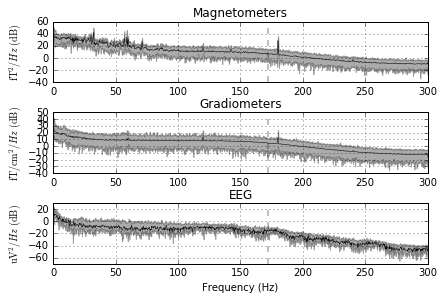

In [56]:
# visualize the raw PSD of our data
raw.plot_psd(area_mode='range',tmax=10.0,show=False,average=True);

### Plot a cleaned PSD

`read_selection()`: focus the visualization on a subset of channels. 


In [57]:
# Pick MEG magnetometers in the Left-temporal region
selection = read_selection('Left-temporal')
picks = mne.pick_types(raw.info,meg='mag',eeg=False,eog=False,
                      stim=False,exclude='bads',selection=selection)
# just look at the first few channels for demonstration purposes
picks = picks[:4]
picks

array([ 2,  8, 11, 14])

####  visualize how this PSD changes after applying some standard filtering techniques. 
 1. first apply the SSP projection; (proj=True)
 2. second perform a notch filter to remove particular frequency bands.


Effective window size : 3.410 (s)


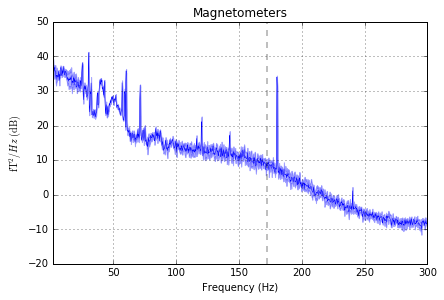

In [58]:
# Without SSP： proj = False
raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=False, color=(0, 0, 1),  picks=picks,
             show=False, average=True);

Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
Effective window size : 3.410 (s)


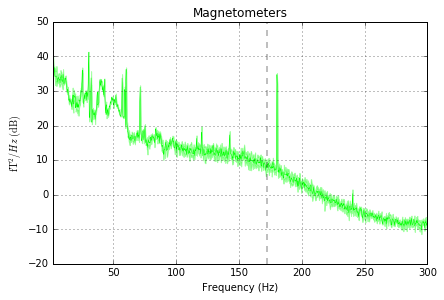

In [59]:
# With SPP： proj = True
raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=True, color=(0, 1, 0), picks=picks,
             show=False, average=True);

Setting up band-stop filter
Filter length of 3965 samples (6.602 sec) selected
Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
Effective window size : 3.410 (s)


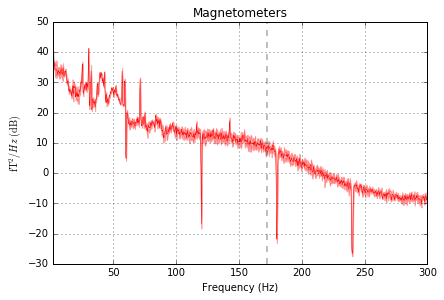

In [60]:
# And now do the same with SSP + notch filtering
# Pick all channels for notch since the SSP projection mixes channels together
copy_raw = raw.copy()
copy_raw.notch_filter(np.arange(60,241,60),n_jobs=1,fir_design='firwin')
copy_raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=True, color=(1, 0, 0), picks=picks,
             show=False, average=True);

Effective window size : 3.410 (s)
Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
Effective window size : 3.410 (s)
Setting up band-stop filter
Filter length of 3965 samples (6.602 sec) selected
Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
Effective window size : 3.410 (s)


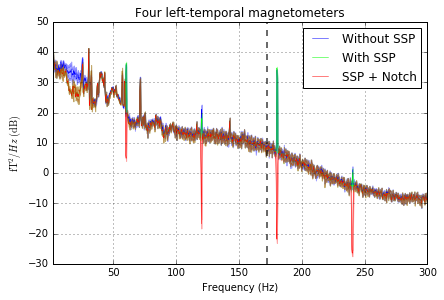

In [61]:
## 合并在一张图来整体看
plt.figure()
ax = plt.axes()
raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=False, ax=ax, color=(0, 0, 1),  picks=picks,
             show=False, average=True)

raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=True, ax=ax, color=(0, 1, 0), picks=picks,
             show=False, average=True)

# And now do the same with SSP + notch filtering
# Pick all channels for notch since the SSP projection mixes channels together
copyraws = raw.copy()
copyraws.notch_filter(np.arange(60, 241, 60), n_jobs=1, fir_design='firwin')
copyraws.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=True, ax=ax, color=(1, 0, 0), picks=picks,
             show=False, average=True)

ax.set_title('Four left-temporal magnetometers')
plt.legend(ax.lines[::3], ['Without SSP', 'With SSP', 'SSP + Notch'])

### Alternative functions for PSDs
- There are also several functions in MNE that create a PSD using a Raw object. These are in the mne.time_frequency module and begin with psd_*. For example, we’ll use a multitaper method to compute the PSD below.

Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
    Using multitaper spectrum estimation with 7 DPSS windows


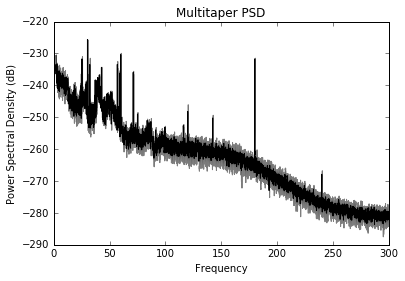

In [62]:
f, ax = plt.subplots()
psds, freqs = psd_multitaper(raw, low_bias=True, tmin=tmin, tmax=tmax,
                             fmin=fmin, fmax=fmax, proj=True, picks=picks,
                             n_jobs=1)
psds = 10 * np.log10(psds)
psds_mean = psds.mean(0)
psds_std = psds.std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD', xlabel='Frequency',
       ylabel='Power Spectral Density (dB)')
plt.show()

### Reference
- https://martinos.org/mne/stable/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html